<a href="https://colab.research.google.com/github/GulTion/BioProject/blob/main/Efficient_Framework_for_Brain_Tumour_Classification_using_Hierarchical_Deep_Learning_Neural_Network_Classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Download of Input Data

In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("awsaf49/brats2020-training-data")

print("Path to dataset files:", path)

100%|██████████| 6.76G/6.76G [01:13<00:00, 98.5MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/awsaf49/brats2020-training-data/versions/3


In [ ]:
! mv /root/.cache/kagglehub/datasets/awsaf49/brats2020-training-data/versions/3 .

In [ ]:
!cd "/content/input/brats2020-training-data/BraTS2020_training_data/content/data" && ls -1 | wc -l

57198


# Traning

In [ ]:
import os
import h5py
import numpy as np
import pandas as pd
from tensorflow.keras import Input
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.utils import to_categorical
from tensorflow.image import resize
from sklearn.model_selection import train_test_split

# Updated Data Loading Function
def load_h5_file(file_path):
    """
    Load an HDF5 file and ensure the image is reshaped to (128, 128, 1) for grayscale input.
    """
    with h5py.File(file_path, 'r') as f:
        # Replace 'image' and 'mask' with actual keys in your HDF5 file
        image = np.array(f['image'])  # Load the MRI image
        mask = np.array(f['mask']) if 'mask' in f else None  # Load the segmentation mask if available

    # Ensure image has 1 channel (convert multi-channel to grayscale if necessary)
    if image.ndim == 3 and image.shape[-1] > 1:  # Multi-channel image
        image = np.mean(image, axis=-1, keepdims=True)  # Convert to grayscale by averaging channels
    elif image.ndim == 2:  # Single-channel, expand dimensions
        image = np.expand_dims(image, axis=-1)

    return image, mask


# Load metadata CSV and file paths
csv_path = "/content/input/brats2020-training-data/BraTS20 Training Metadata.csv"  # Replace with your actual CSV file path
data = pd.read_csv(csv_path)

# Get all file paths from the dataset
file_paths = ["/content" + row['slice_path'][2:] for _, row in data.iterrows()]  # Adjust slice path
labels = data['target'].values  # Labels corresponding to the files

# Model Definition
def create_model(input_shape, num_classes):
    model = Sequential([
        Input(shape=input_shape),
        Conv2D(32, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Conv2D(128, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(num_classes, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# Batch Loading Function
def load_batch(file_paths, labels, start_index, batch_size):
    images = []
    masks = []
    batch_labels = labels[start_index:start_index + batch_size]

    for file_path in file_paths[start_index:start_index + batch_size]:
        try:
            image, mask = load_h5_file(file_path)
            # Resize image and mask to 128x128
            resized_image = resize(image, [128, 128]).numpy()
            resized_mask = resize(mask, [128, 128]).numpy() if mask is not None else np.zeros((128, 128))
            images.append(resized_image)
            masks.append(resized_mask)
        except (OSError, KeyError) as e:
            print(f"Error loading {file_path}: {e}")
            continue

    # Normalize and convert to numpy arrays
    images = np.array(images) / 255.0
    masks = np.array(masks)
    batch_labels = np.array(batch_labels)

    # One-hot encode labels
    num_classes = len(np.unique(labels))
    batch_labels = to_categorical(batch_labels, num_classes=num_classes)

    return images, masks, batch_labels

# Incremental Training
batch_size = 4000  # Number of files to process in each batch
total_files = len(file_paths)
input_shape = (128, 128, 1)  # Example input shape
num_classes = len(np.unique(labels))

# Initialize model
model = create_model(input_shape, num_classes)

for start_index in range(0, total_files, batch_size):
    print(f"Processing batch: {start_index} to {start_index + batch_size}")

    # Load a batch of data
    X_batch, masks_batch, y_batch = load_batch(file_paths, labels, start_index, batch_size)

    # Split batch into training and validation sets
    X_train, X_val, y_train, y_val = train_test_split(X_batch, y_batch, test_size=0.2, random_state=42)

    # Train the model on the current batch
    model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=5,  # Train for a small number of epochs per batch
        batch_size=16
    )

# Evaluate Model on Test Data (optional if you have separate test data)
# X_test, masks_test, y_test = load_batch(test_file_paths, test_labels, 0, len(test_file_paths))
# test_loss, test_accuracy = model.evaluate(X_test, y_test)
# print(f"Test Loss: {test_loss:.4f}")
# print(f"Test Accuracy: {test_accuracy:.4f}")

# Save the final model
model.save("brain_tumor_classifier_final.keras")


Processing batch: 0 to 4000
Epoch 1/5
200/200 ━━━━━━━━━━━━━━━━━━━━ 10s 15ms/step - accuracy: 0.6791 - loss: 0.5858 - val_accuracy: 0.8288 - val_loss: 0.3898
Epoch 2/5
200/200 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - accuracy: 0.7755 - loss: 0.4505 - val_accuracy: 0.8263 - val_loss: 0.3945
Epoch 3/5
200/200 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.7985 - loss: 0.4117 - val_accuracy: 0.8138 - val_loss: 0.3815
Epoch 4/5
200/200 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - accuracy: 0.8163 - loss: 0.4040 - val_accuracy: 0.8525 - val_loss: 0.3253
Epoch 5/5
200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.8170 - loss: 0.3937 - val_accuracy: 0.8763 - val_loss: 0.3120
Processing batch: 4000 to 8000
Epoch 1/5
200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.7906 - loss: 0.4253 - val_accuracy: 0.8250 - val_loss: 0.3711
Epoch 2/5
200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.8450 - loss: 0.3571 - val_accuracy: 0.8550 - val_loss: 0.3206
Epoch 3/5
200/200 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/

# Testing

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 686ms/step


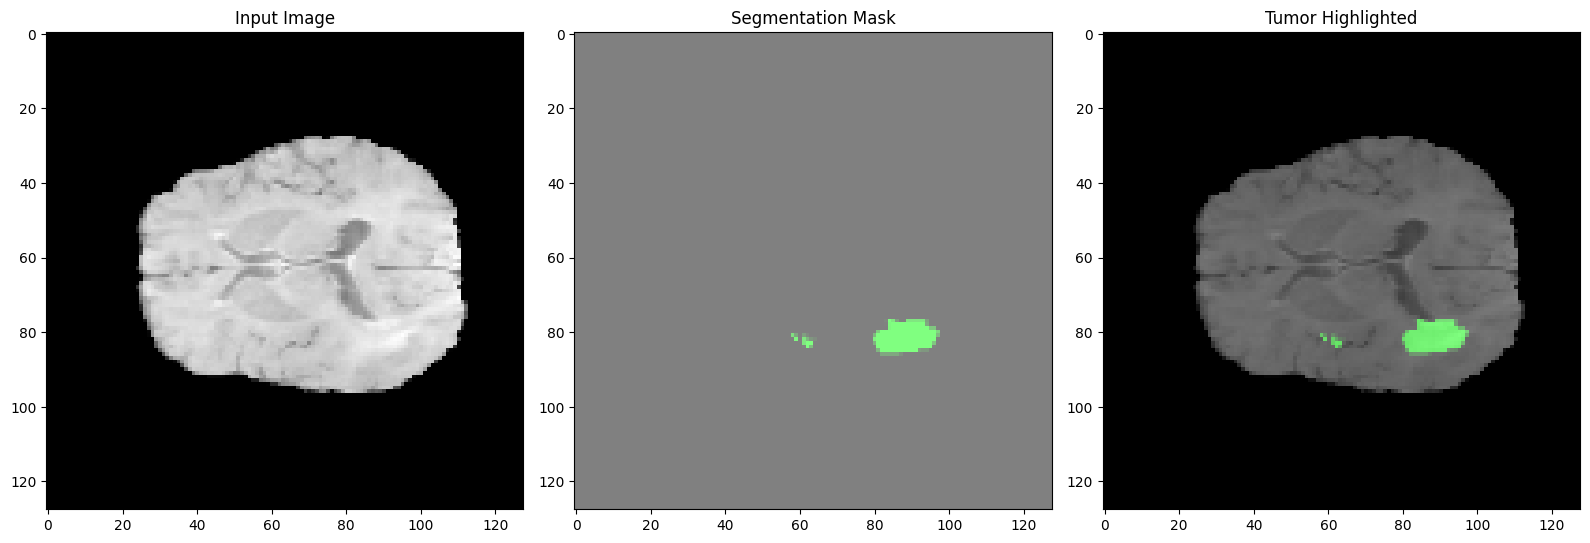

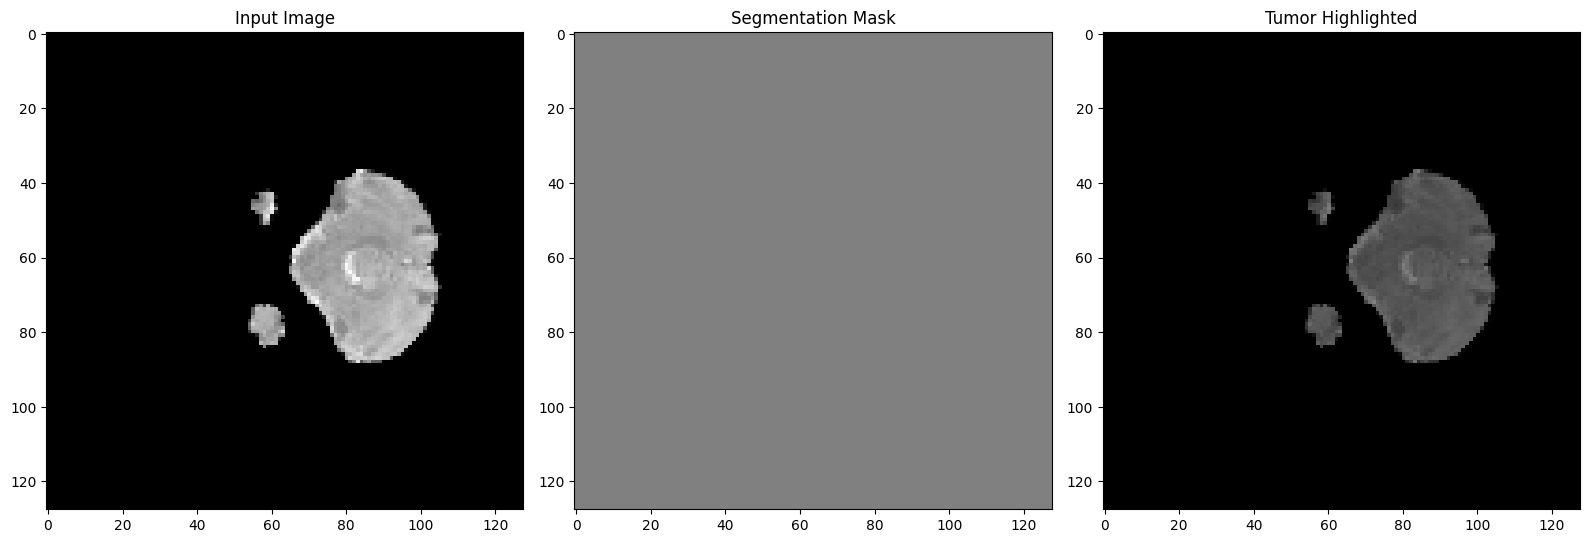

<ipython-input-8-58497f2558c1>:73: RuntimeWarning: invalid value encountered in divide
  normalized_image = (X_test[i].squeeze() - X_test[i].min()) / (X_test[i].max() - X_test[i].min())


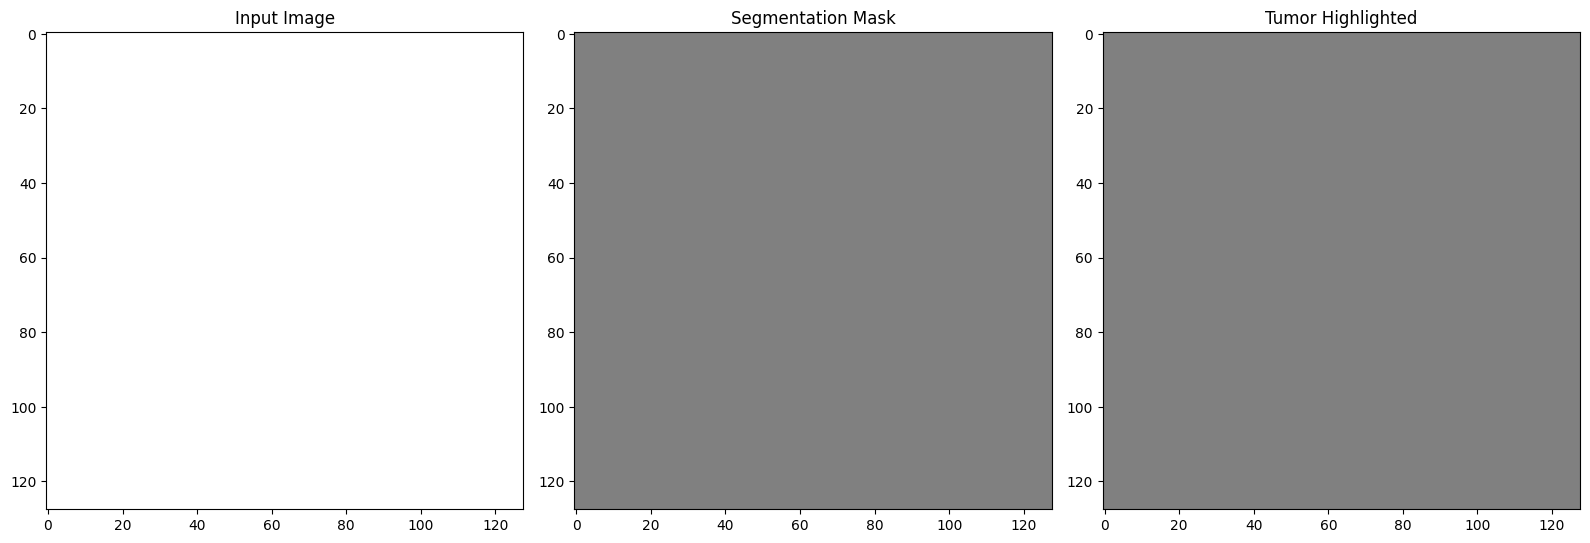

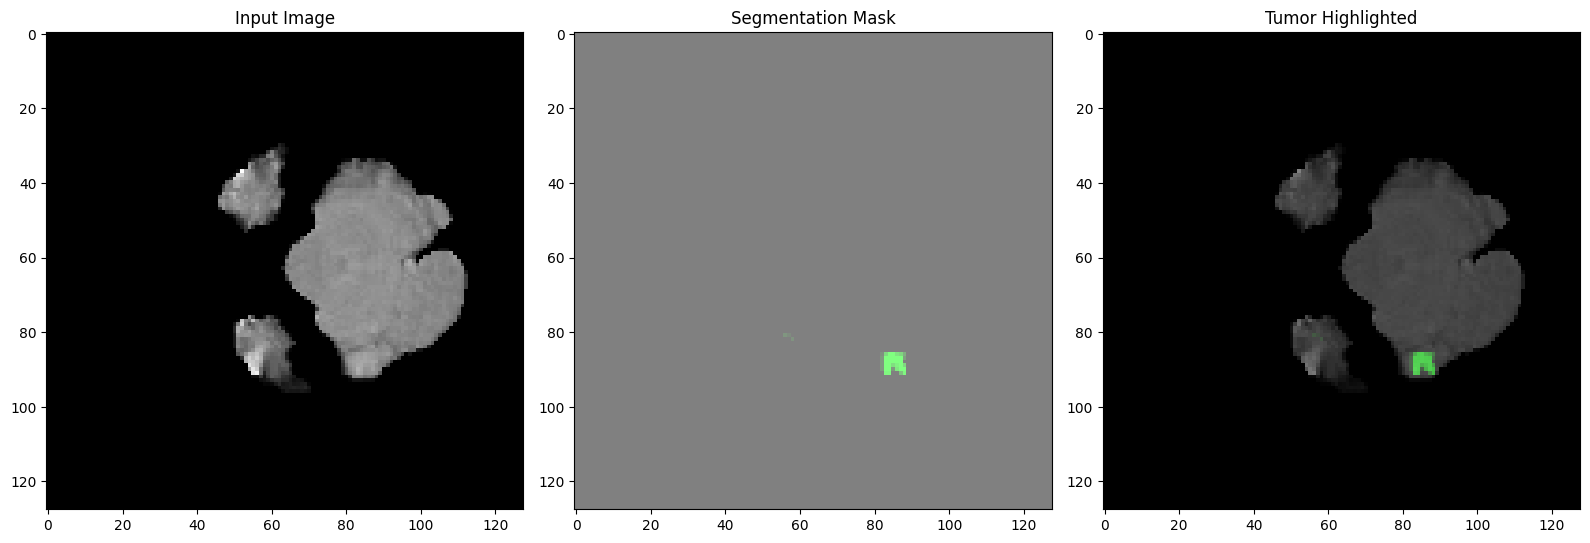

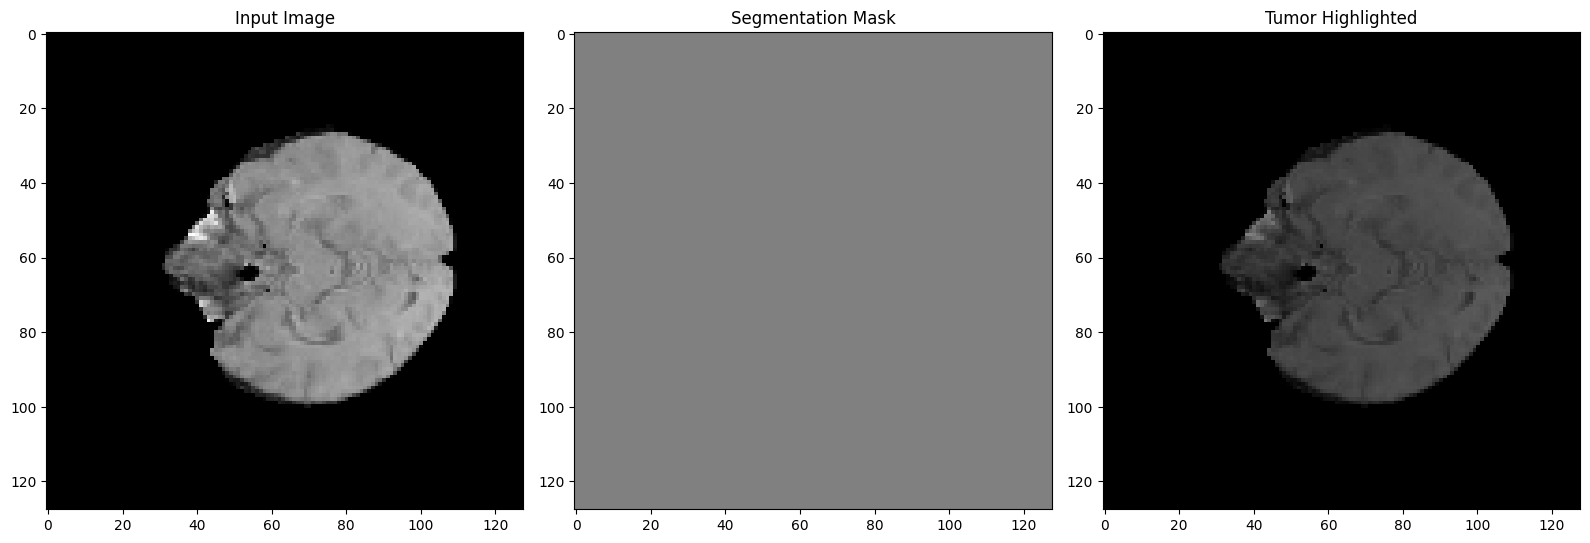

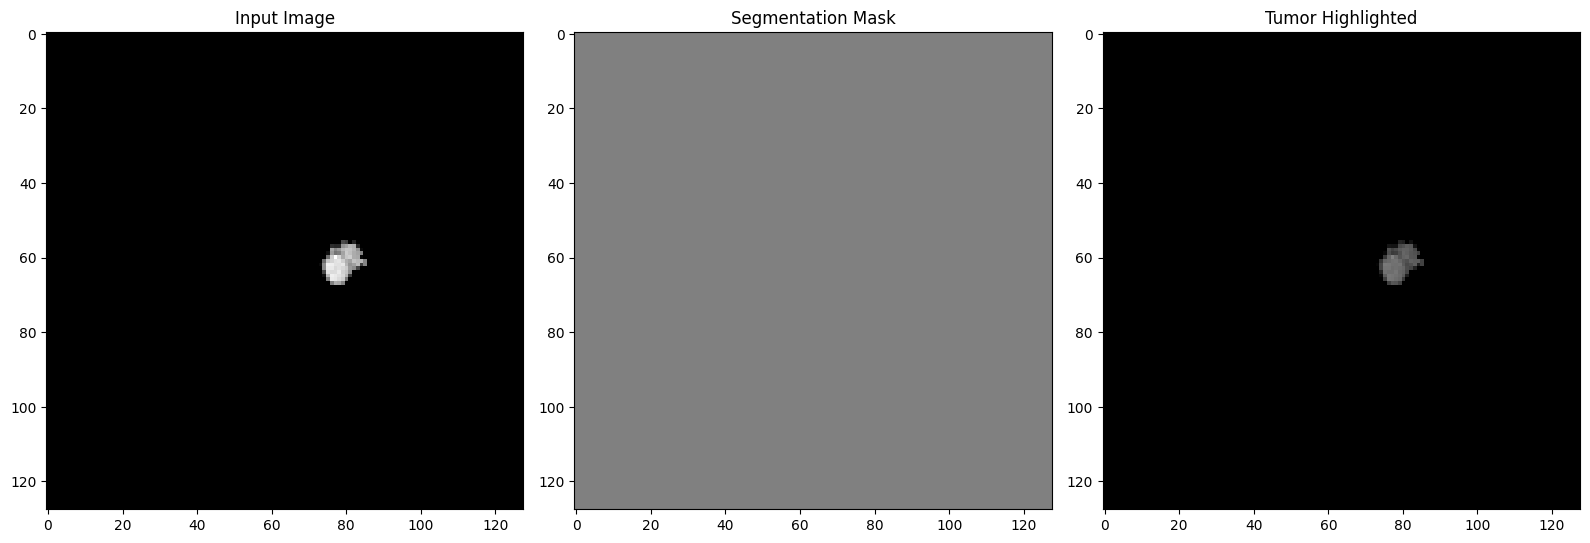

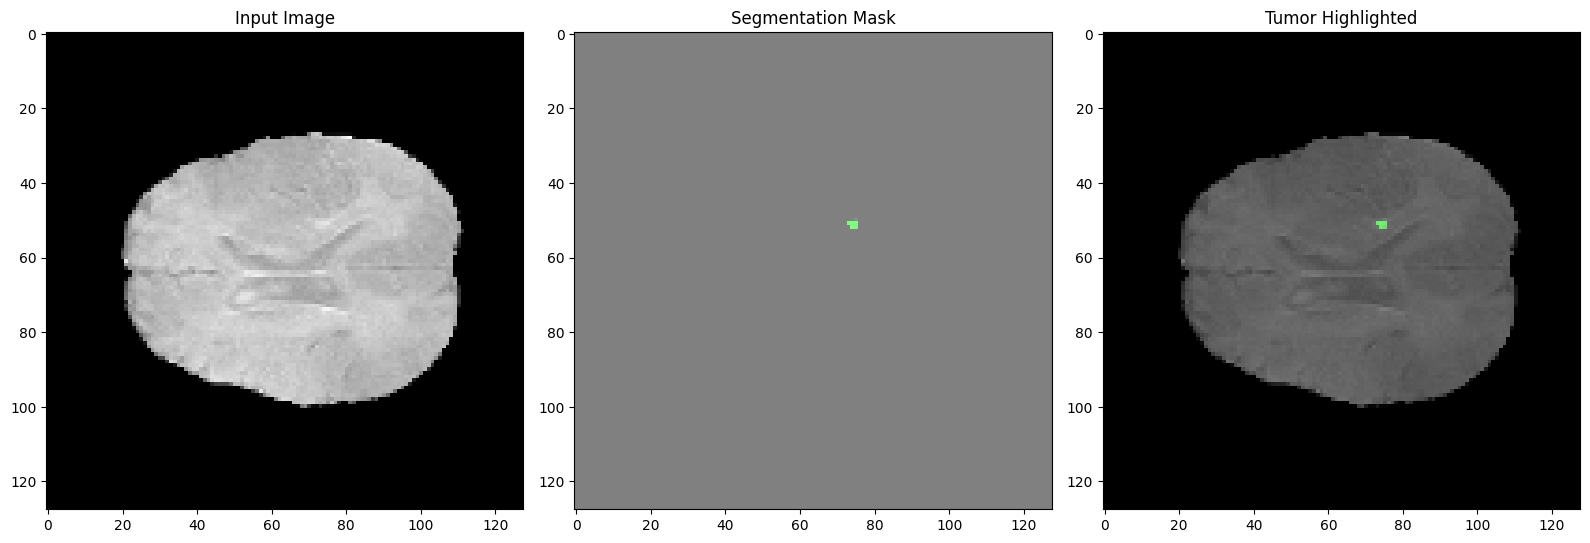

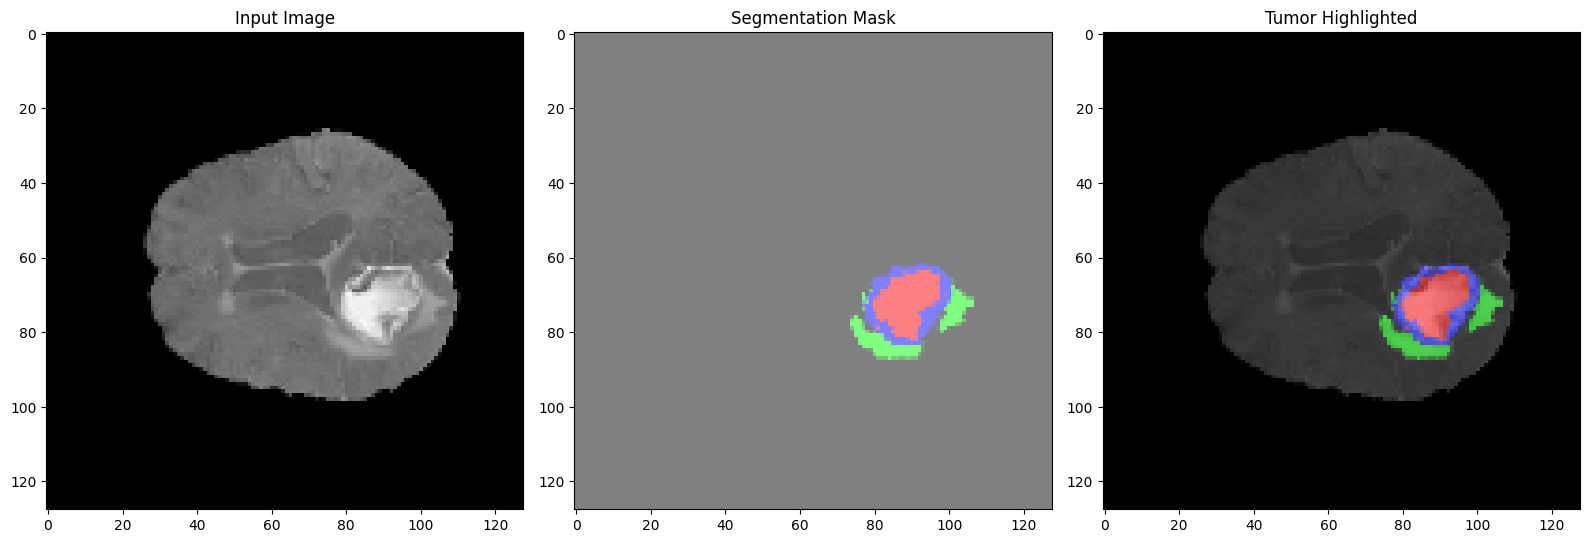

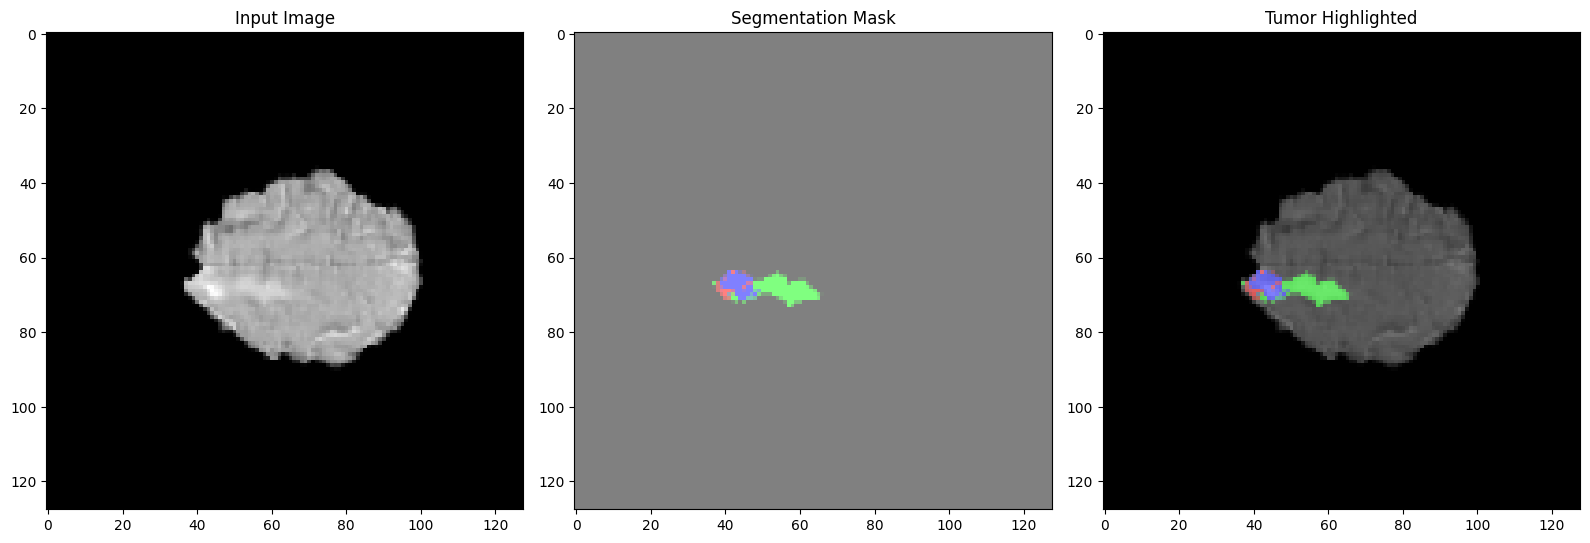

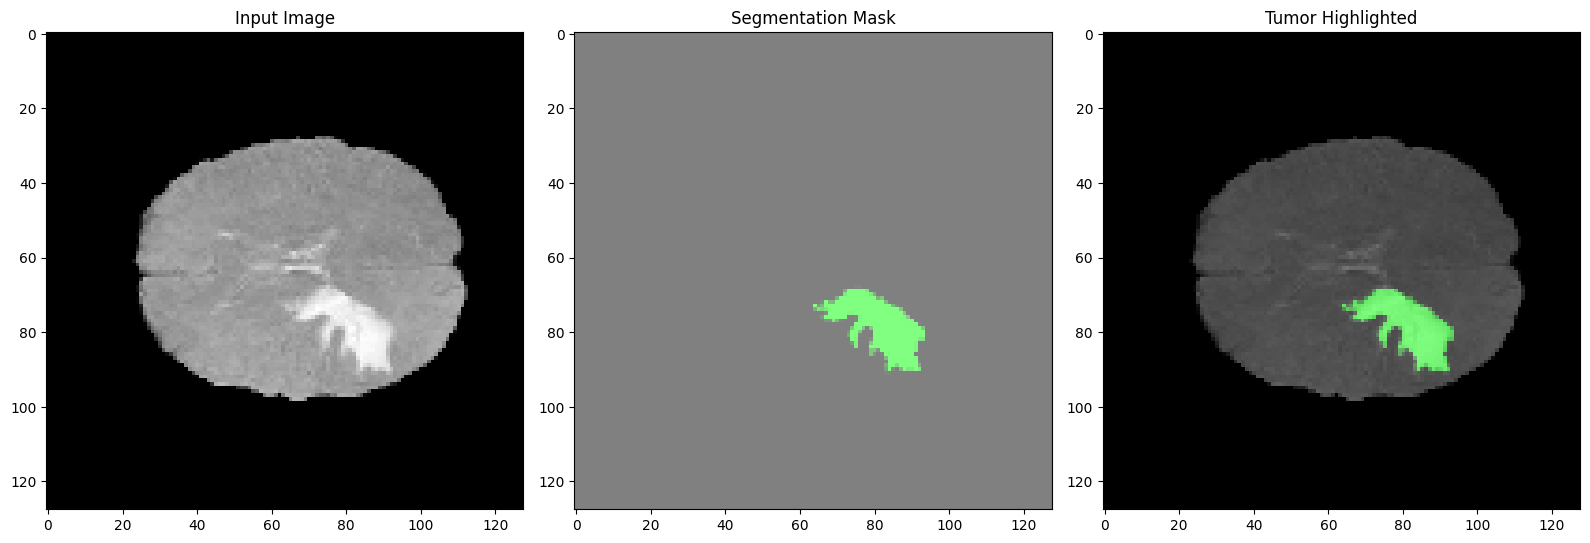

In [ ]:
import os
import h5py
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
from tensorflow.image import resize

def test_and_visualize(model_path, h5_directory, num_files=5):
    """
    Test and visualize the tumor-highlighted predictions for a given number of `.h5` files.

    Parameters:
        model_path (str): Path to the saved model file.
        h5_directory (str): Path to the directory containing `.h5` files.
        num_files (int): Number of files to test and visualize.
    """
    # Load the saved model
    model = load_model(model_path)

    # Function to load `.h5` files
    def load_h5_file(file_path):
        with h5py.File(file_path, 'r') as f:
            image = np.array(f['image'])  # Load the MRI image
            mask = np.array(f['mask']) if 'mask' in f else None  # Load the segmentation mask if available

        # Ensure image has 1 channel (convert multi-channel to grayscale if necessary)
        if image.ndim == 3 and image.shape[-1] > 1:
            image = np.mean(image, axis=-1, keepdims=True)  # Convert to grayscale by averaging channels
        elif image.ndim == 2:
            image = np.expand_dims(image, axis=-1)  # Add channel dimension for single-channel images

        return image, mask

    # Function to load and preprocess test data
    def load_test_data(file_paths, num_samples):
        images = []
        masks = []
        for file_path in file_paths[:num_samples]:
            try:
                image, mask = load_h5_file(file_path)
                # Resize image and mask to 128x128
                resized_image = resize(image, [128, 128]).numpy()
                resized_mask = resize(mask, [128, 128]).numpy() if mask is not None else np.zeros((128, 128))
                images.append(resized_image)
                masks.append(resized_mask)
            except (OSError, KeyError) as e:
                print(f"Error loading {file_path}: {e}")
                continue

        images = np.array(images) / 255.0  # Normalize images
        masks = np.array(masks)
        return images, masks

    # List all `.h5` files in the directory
    file_paths = [os.path.join(h5_directory, fname) for fname in os.listdir(h5_directory) if fname.endswith(".h5")]

    # Load the specified number of test files
    X_test, masks_test = load_test_data(file_paths, num_samples=num_files)

    # Placeholder for dummy `y_test` (replace with actual labels if available)
    num_classes = model.output_shape[-1]  # Get the number of classes from the model
    y_test = np.zeros((X_test.shape[0], num_classes))  # Create a placeholder one-hot encoded array

    # Predictions and Visualization
    predictions = model.predict(X_test)
    predicted_classes = np.argmax(predictions, axis=1)
    true_classes = np.argmax(y_test, axis=1)  # Use true labels if available

    for i in range(len(X_test)):
        segmentation_mask = masks_test[i]

        # Normalize the input image for visualization
        normalized_image = (X_test[i].squeeze() - X_test[i].min()) / (X_test[i].max() - X_test[i].min())

        plt.figure(figsize=(16, 6))

        # Original Input Image
        plt.subplot(1, 3, 1)
        plt.imshow(normalized_image, cmap='gray')
        plt.title("Input Image")

        # Segmentation Mask
        plt.subplot(1, 3, 2)
        plt.imshow(segmentation_mask, cmap='Reds', alpha=0.5)
        plt.title("Segmentation Mask")

        # Highlighted Image
        plt.subplot(1, 3, 3)
        plt.imshow(normalized_image, cmap='gray')
        plt.imshow(segmentation_mask, cmap='Reds', alpha=0.5)  # Overlay the mask
        plt.title("Tumor Highlighted")

        plt.tight_layout()
        plt.show()

# Example Usage:
# Specify the model path and HDF5 directory
model_path = "brain_tumor_classifier_final.keras"
h5_directory = "/content/input/brats2020-training-data/BraTS2020_training_data/content/data/"
num_files_to_test = 10  # Number of files to test

# Call the function to test and visualize
test_and_visualize(model_path, h5_directory, num_files=num_files_to_test)


# Accuracy Calculation

125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8506 - loss: 0.8620
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step

Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.90      0.85      2263
           1       0.85      0.70      0.77      1737

    accuracy                           0.81      4000
   macro avg       0.82      0.80      0.81      4000
weighted avg       0.82      0.81      0.81      4000


Confusion Matrix:
[[2044  219]
 [ 522 1215]]


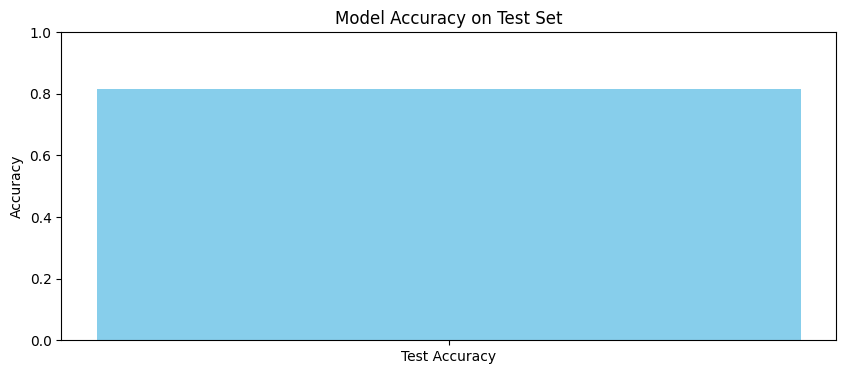

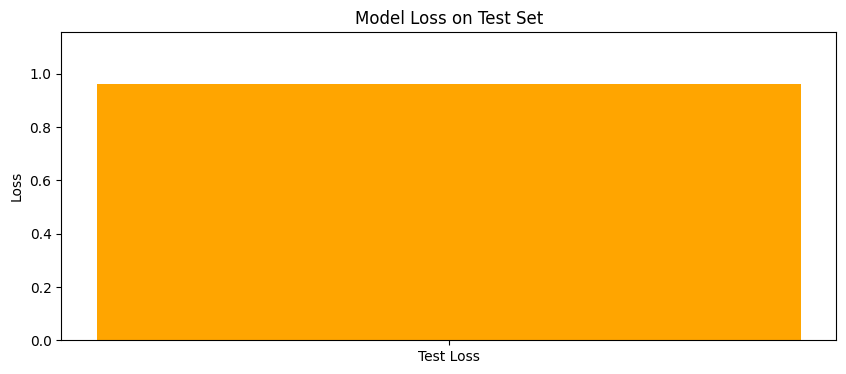

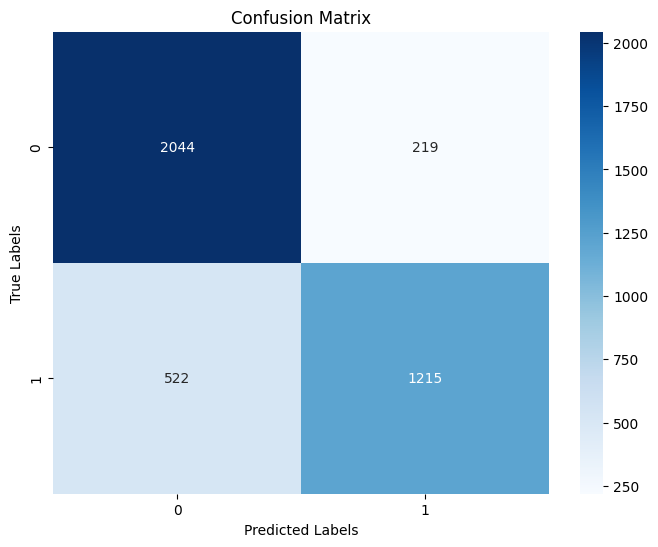

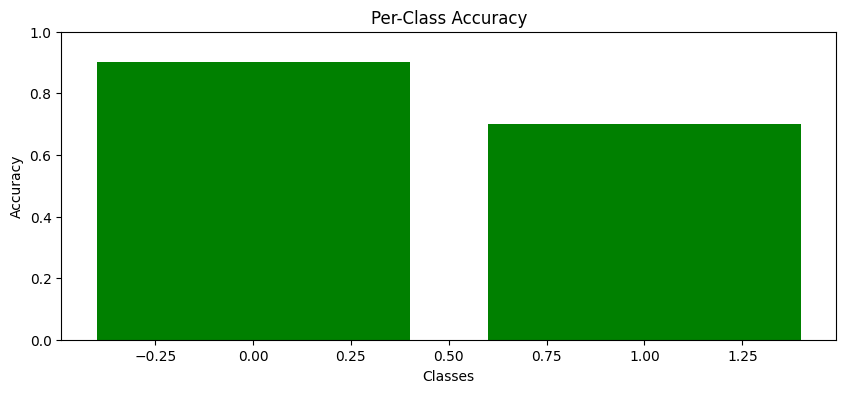

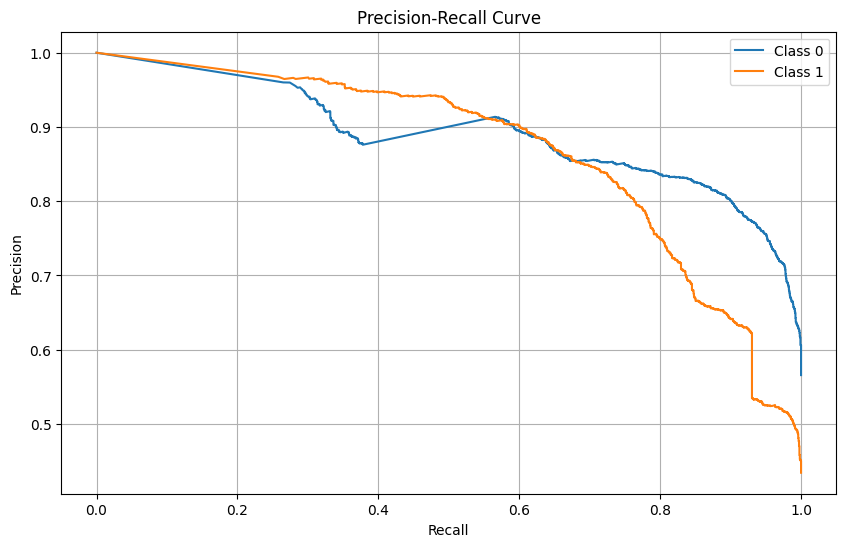

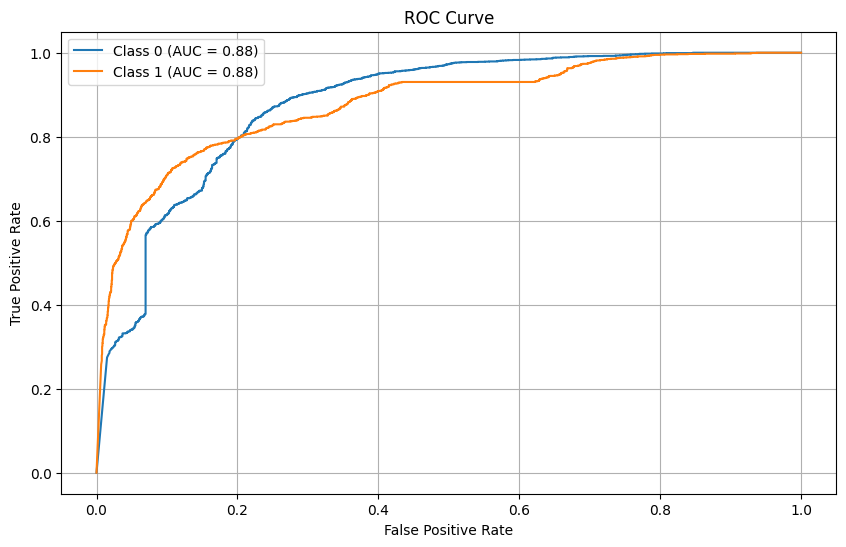

In [ ]:
import os
import h5py
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
from tensorflow.image import resize
from sklearn.metrics import (
    confusion_matrix,
    classification_report,
    roc_curve,
    auc,
    precision_recall_curve,
)
import seaborn as sns


def test_model_with_all_graphs(model_path, h5_directory, csv_file_path, num_files=1000):
    """
    Test the model and generate comprehensive graphs for evaluation.

    Parameters:
        model_path (str): Path to the saved model file.
        h5_directory (str): Path to the directory containing `.h5` files.
        csv_file_path (str): Path to the CSV file containing labels and metadata.
        num_files (int): Number of files to test.
    """
    # Load the saved model
    model = load_model(model_path)

    # Load the CSV file
    data = pd.read_csv(csv_file_path)

    # Filter to include only the first `num_files`
    data = data.head(num_files)

    # Function to load `.h5` files
    def load_h5_file(file_path):
        with h5py.File(file_path, 'r') as f:
            image = np.array(f['image'])  # Load the MRI image
            mask = np.array(f['mask']) if 'mask' in f else None  # Load the segmentation mask if available

        # Ensure image has 1 channel (convert multi-channel to grayscale if necessary)
        if image.ndim == 3 and image.shape[-1] > 1:
            image = np.mean(image, axis=-1, keepdims=True)  # Convert to grayscale by averaging channels
        elif image.ndim == 2:
            image = np.expand_dims(image, axis=-1)  # Add channel dimension for single-channel images

        return image, mask

    # Prepare test data
    images = []
    masks = []
    labels = []

    for _, row in data.iterrows():
        file_name = f"volume_{row['volume']}_slice_{row['slice']}.h5"
        file_path = os.path.join(h5_directory, file_name)

        try:
            # Load image and mask from the `.h5` file
            image, mask = load_h5_file(file_path)
            resized_image = resize(image, [128, 128]).numpy()
            resized_mask = resize(mask, [128, 128]).numpy() if mask is not None else np.zeros((128, 128))

            images.append(resized_image)
            masks.append(resized_mask)
            labels.append(row['target'])  # Use target from CSV
        except (OSError, KeyError) as e:
            print(f"Error loading {file_path}: {e}")
            continue

    # Convert to numpy arrays
    X_test = np.array(images) / 255.0  # Normalize images
    masks_test = np.array(masks)
    y_test = np.array(labels)

    # One-hot encode labels for model prediction
    num_classes = model.output_shape[-1]
    y_test_one_hot = np.zeros((len(y_test), num_classes))
    for i, label in enumerate(y_test):
        y_test_one_hot[i, label] = 1

    # Evaluate the model
    test_loss, test_accuracy = model.evaluate(X_test, y_test_one_hot, verbose=1)

    # Make predictions
    predictions = model.predict(X_test)
    predicted_classes = np.argmax(predictions, axis=1)

    # Classification Report
    print("\nClassification Report:")
    print(classification_report(y_test, predicted_classes))

    # Confusion Matrix
    cm = confusion_matrix(y_test, predicted_classes)
    print("\nConfusion Matrix:")
    print(cm)

    # Visualization
    # Plot 1: Accuracy and Loss
    plt.figure(figsize=(10, 4))
    plt.bar(["Test Accuracy"], [test_accuracy], color="skyblue")
    plt.title("Model Accuracy on Test Set")
    plt.ylabel("Accuracy")
    plt.ylim(0, 1)
    plt.show()

    plt.figure(figsize=(10, 4))
    plt.bar(["Test Loss"], [test_loss], color="orange")
    plt.title("Model Loss on Test Set")
    plt.ylabel("Loss")
    plt.ylim(0, max(test_loss * 1.2, 1))
    plt.show()

    # Plot 2: Confusion Matrix Heatmap
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
    plt.xlabel("Predicted Labels")
    plt.ylabel("True Labels")
    plt.title("Confusion Matrix")
    plt.show()

    # Plot 3: Per-Class Accuracy
    per_class_accuracy = cm.diagonal() / cm.sum(axis=1)
    plt.figure(figsize=(10, 4))
    plt.bar(np.unique(y_test), per_class_accuracy, color="green")
    plt.title("Per-Class Accuracy")
    plt.xlabel("Classes")
    plt.ylabel("Accuracy")
    plt.ylim(0, 1)
    plt.show()

    # Plot 4: Precision-Recall Curve
    plt.figure(figsize=(10, 6))
    for i in range(num_classes):
        precision, recall, _ = precision_recall_curve(y_test_one_hot[:, i], predictions[:, i])
        plt.plot(recall, precision, label=f"Class {i}")
    plt.title("Precision-Recall Curve")
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.legend()
    plt.grid()
    plt.show()

    # Plot 5: ROC Curve
    plt.figure(figsize=(10, 6))
    for i in range(num_classes):
        fpr, tpr, _ = roc_curve(y_test_one_hot[:, i], predictions[:, i])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f"Class {i} (AUC = {roc_auc:.2f})")
    plt.title("ROC Curve")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.legend()
    plt.grid()
    plt.show()


# Example Usage:
# Specify the model path, HDF5 directory, and CSV file path
model_path = "brain_tumor_classifier_final.keras"
h5_directory = "/content/input/brats2020-training-data/BraTS2020_training_data/content/data/"
csv_file_path = "/content/input/brats2020-training-data/BraTS20 Training Metadata.csv"

# Call the function to test and visualize comprehensive graphs
test_model_with_all_graphs(model_path, h5_directory, csv_file_path, num_files=4000)
